## PyPSA Übung 07

Das Land Nordrhein-Westfalen (NRW) möchte im Rahmen des Projektes **_NRW_Battery_** Batteriegroßspeicher in den Regierungsbezirk (RBZ) (Arnsberg, Detmold, Köln, Düsseldorf und Münster) errichten, um die Stromerzeugung auf Photovoltaik und Windenergie umzustellen. Dabei ist unklar, welche zusätzliche erneuerbare Leistung und welche Speicherkapazität benötigt wird. Eine Abschätzung der notwendigen Leistungen und Kapazitäten sollen Sie auf Grundlage der Ihnen bereitgestellten, aggregierten Daten liefern. Ihnen werden folgende Daten übermittelt:
> - Ein normalisiertes Lastprofil der stündlichen Last pro Kopf in kW ('load_profile_normalized.csv')
> Kostenparameterer
> - Geolocations ('result_template_xxxxx.json') zu geografischen Mittelpunkten und Grenzen der Regierungsbezirke und NRW, sowie Liniengeometrien der Luftlinie zwischen den Regierungsbezirken
> - Datensatz ('nrw_plants_data.pkl') mit normalisierten PV- und Winderzeugungsprofilen, Einwohnerzahlen, Distanzen zwischen den Regierungsbezirken unten zu fossilen Kraftwerken und deren Gesamtleistung je Regierungsbezirkzirk
> - Ein-Ausspeicherwirkungsgrad des Batteriespeichers wird mit 90% geschätzt.

Ihre Ergebnisdaten sollen anhand einer interaktiven Karte dargestellt werden. Gleichzeitig ist das Bild eine Skizze für das Netzwerk. Dargestellt sind die Regierungsbezirke in **Blau**, die geografischen Mittelpunkte der Regierungsbezirke als Referenzknoten in **Schwarz** und die NRW_Battery als geografischer Mittelpunkt des Landes NRW in **Rot**: 


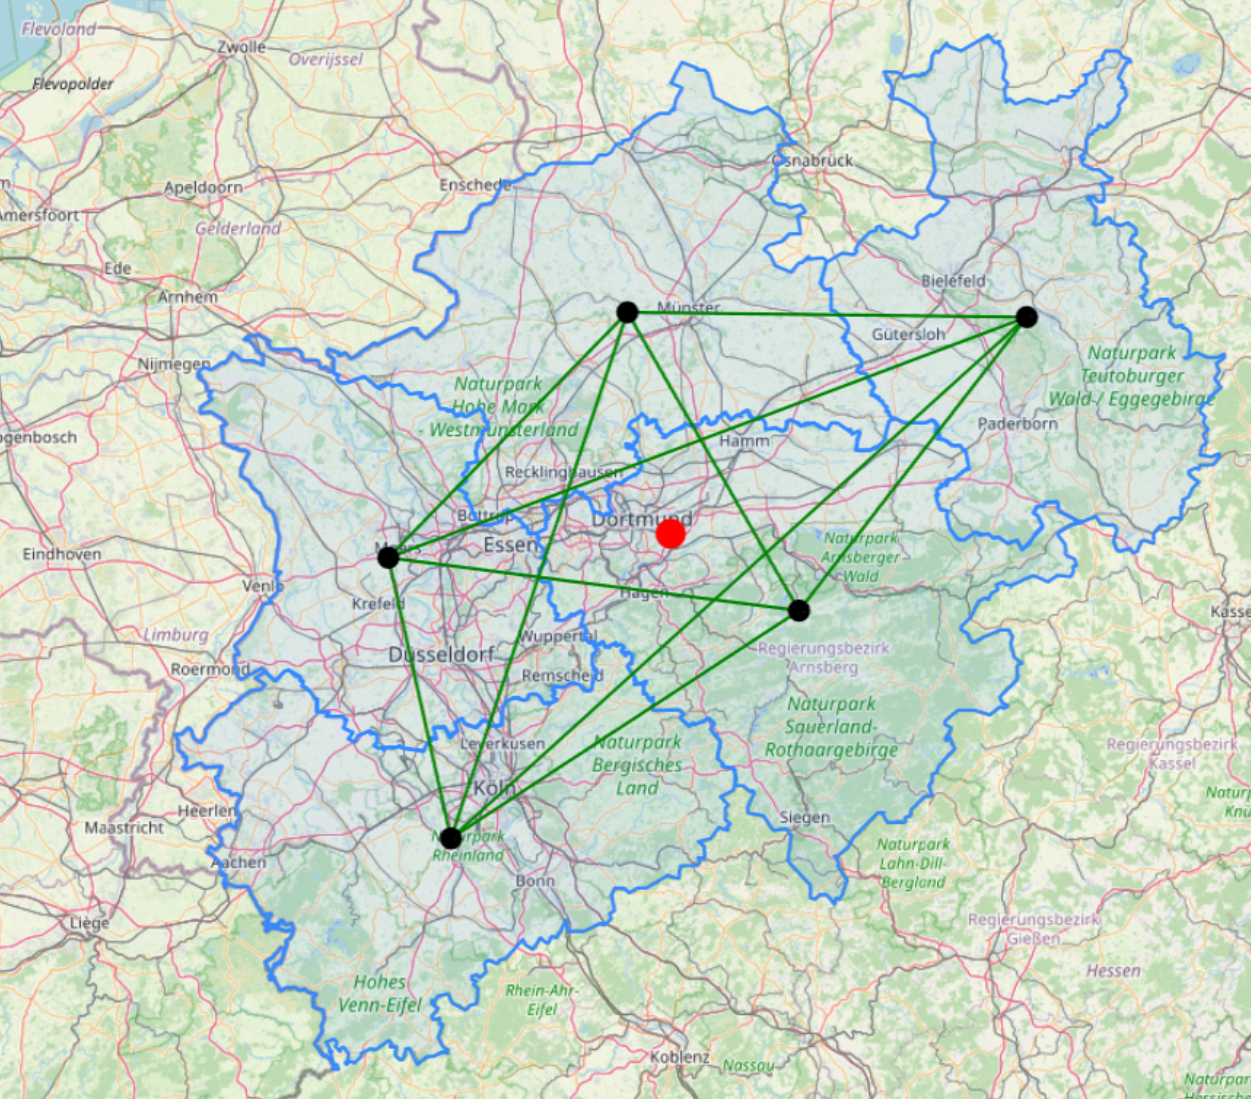

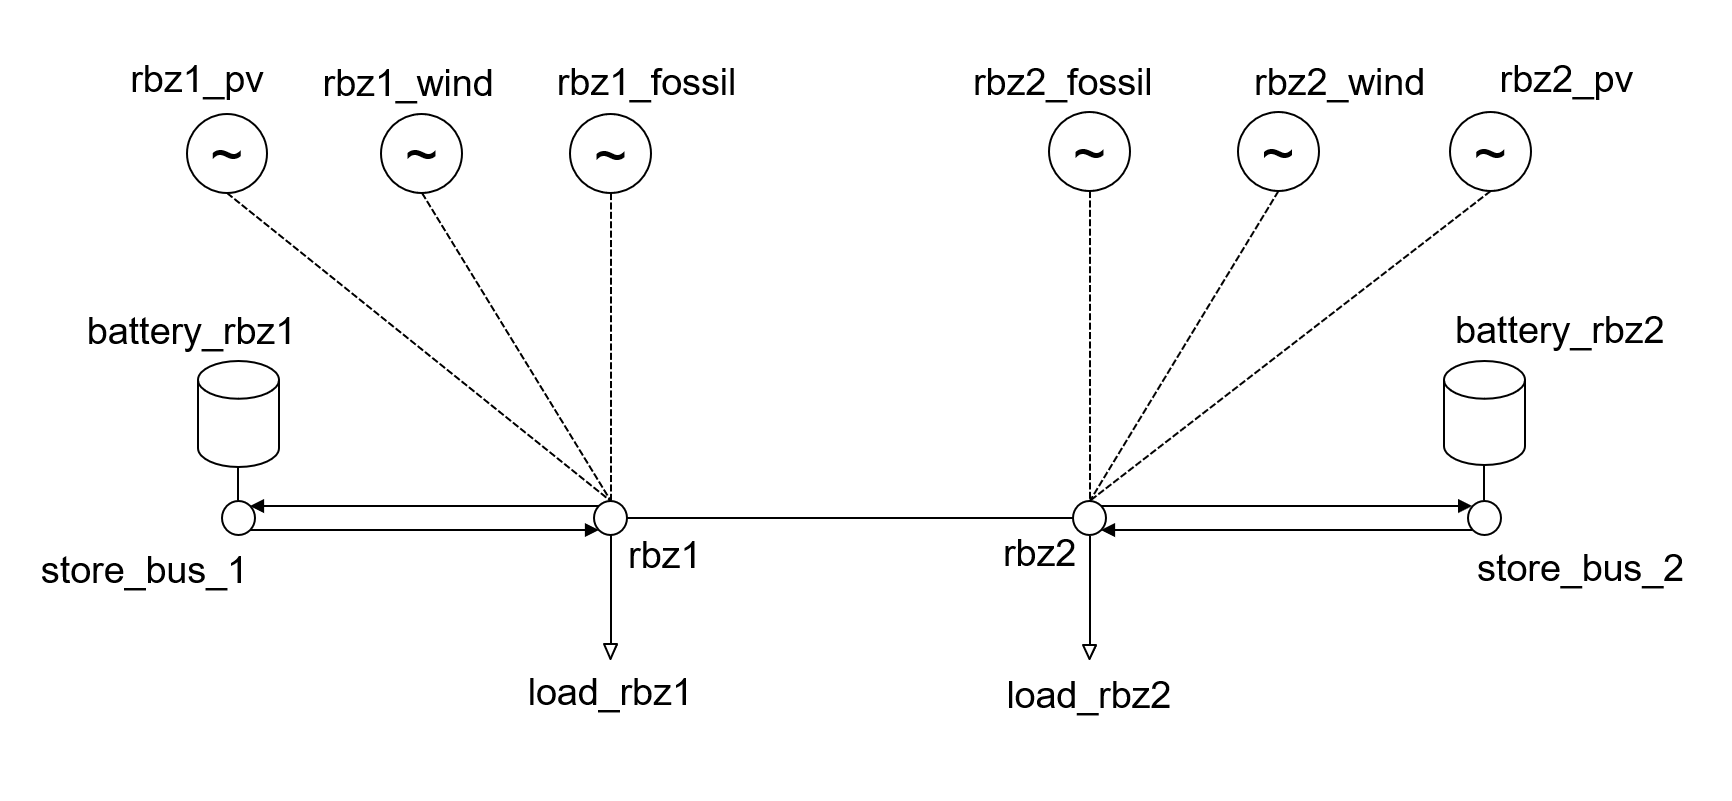


Hinweis:
- Implementieren Sie immer nur die Komponenten, die im jeweiligen Schritt gefordert sind.
- Sie werden im Verlauf der Übung das Netzwerk Schrittweise erweitern und Zwischenergebnisse für verschiedene Szenarien speichern.
- Ganz zum Schluss erzeugen Sie die interaktive Karte als Endergebnis

Importieren Sie zunächst die im _import-Kommentar_ angegebenen Bibliotheken

In [1]:
# import libraries pandas, geopandas, numpy, pypsa, matplotlib.pyplot
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import matplotlib.pyplot as plt

### Funktionen
Ihnen werden zusätzlich zwei Funktionen bereitgestellt, die für den Netzwerk- und Szenarienaufbau hilfreich sein können.

In [2]:
# set a temporary blackout in RBZ-area (Optional)
def set_blackout_condition(network, start_month=1, start_week=1, blackout_duration=1, rbz='Koeln'):
    """
    Set blackout conditions for a specific month and location.

    Parameters:
    - network (PyPSA.Network): The PyPSA network to modify.
    - start_month (int, optional): The month in which blackout conditions will be set to start (default is 1).
    - start_week (int, optional): The week within month in which blackout conditions will be set to start (default is 1, values accepted: [1,2,3,4]).
    - blackout_duration (int, optional): The duration hours for which blackout conditions will be set (default is 1 hour).
    - rbz (str, optional): The location identifier where blackout conditions are to be set (default is 'Koeln').

    Returns:
    Hours when Blackout starts and ends

    Sets blackout conditions in the network for the specified month and location. Blackout conditions entail 
    restricting power generation from photovoltaic (PV) and wind generators, as well as shutting down other 
    types of power plants in the region for the designated time period.

    """
    # calculating blackout start and end point
    h_per_month = [0, 744, 1416, 2159, 2879, 3623, 4343, 5087, 5831, 6551, 7296, 8016]
    h_per_week = 144
    if start_week > 4:
        start_week = 4
    start = h_per_month[start_month - 1] + (start_week - 1) * h_per_week
    end = start + blackout_duration

    # define the generators indicator and set up the p_max_pu profile for a temporary blackout
    blackout_keys = [rbz[:3] + x for x in ['_PV', '_Wind', '_Fossil']]
    blackout_p_max_pu = {
        blackout_keys[0] : [0 if start <= i <= end else x for i, x in enumerate(nrw_plant_data.loc[rbz, 'pv_profile'])],
        blackout_keys[1] : [0 if start <= i <= end else x for i, x in enumerate(nrw_plant_data.loc[rbz, 'wind_profile'])]
    }

    # if fossil power plants included set up also the blackout for fossil power plants p_max_pu
    if blackout_keys[2] in list(network.generators.index):
        blackout_p_max_pu[blackout_keys[2]] = [0 if start <= i <= end else 1 for i in range(8760)]

    # apply blackout conditions to network
    for key, val in blackout_p_max_pu.items():
        network.generators_t.p_max_pu[key] = val
        print('blackout condition set for: ', rbz + ', generator key: ' + key)

    return start, end


In [3]:
# link up all buses with lines
def link_up_buses(rbz_list, nrw_data, network, line_type="149-AL1/24-ST1A 110.0"):
    """
    Create connections between rbzes in the network based on the provided rbz_list.
    
    Args:
        rbz_list (list): List of rbz names.
        nrw_data (DataFrame): Dataframe containing distance information between rbz pairs.
        network (PyPSA.Network): PyPSA network.
        line_type (str, optional): Type of line to be added. Defaults to "149-AL1/24-ST1A 110.0".
    
    Returns:
        None
    """
    # data storage for already built bus connections
    used_rbz_combinations = ['Koe_Koe', 'Arn_Arn', 'Det_Det', 'Due_Due', 'Mue_Mue']
    
    # loop over rbz_names and numerate them
    for i, rbz in enumerate(rbz_list):
        # loop over index numbers again as second loop variable
        for j in range(len(rbz_list)):
            # built both combinations out of the current rbz_name
            name = rbz[:3] + '_' + rbz_list[(i+j)%len(rbz_list)][:3]
            name_rev = rbz_list[(i+j)%len(rbz_list)][:3] + '_' + rbz[:3]
            # if bus combination is not already connected
            if name not in used_rbz_combinations:
                # add the current combinations to the data storage
                used_rbz_combinations.append(name)
                used_rbz_combinations.append(name_rev)
                # add line to network between buses
                network.add('Line', name = name, bus0 = rbz, bus1 = rbz_list[(i+j)%len(rbz_list)],
                            type=line_type, length=nrw_data.loc[rbz, 'distance_' + rbz_list[(i+j)%len(rbz_list)][:3]], 
                            s_nom_extendable = True)
                
            # if already connceted combination, move to next element
            else:
                continue

### Daten Import
Laden Sie als erstes die Datensätze in pandas DataFrames ein. Nutzen Sie hierzu **_read_csv()_** und **_read_pickle()_**. Erstellen Sie dann Variablen oder Dictionaries für die Kostenannahmen und Komponentenparameter. Lesen Sie zum Schluss die bereitgestellten Geodatenpunkte in GeoDataFrames mit der **_from_file()_**-Funktion der Geopandas Klasse _GeoDataFrame_ ein. 

In [4]:
# load data
nrw_plant_data = pd.read_pickle('nrw_plants_data.pkl')
load_profile = pd.read_csv('load_profile_normalized.csv', index_col=0)

# cost data
power_plant_marginal_cost = 45 # €/MWh
capex_wind = 1100000 # €/MW
capex_pv = 430000 # €/MW
capex_battery = 350000 # €/MWh

# battery data
battery_efficiency = 0.9

# Geodaten
gdf_nrw_buses = gpd.GeoDataFrame.from_file('result_template_buses.json').set_index('Bus', drop=True)
gdf_nrw_grid = gpd.GeoDataFrame.from_file('result_template_grid.json').set_index('Line', drop=True)
gdf_nrw_rbz = gpd.GeoDataFrame.from_file('result_template_rbz.json').set_index('RBZ', drop=True)
gdf_nrw_center = gpd.GeoDataFrame.from_file('result_template_nrw_center.json').set_index('NRW', drop=True)

### Datenüberblick
Hier können Sie sich einen Überblick über die Daten verschaffen, indem Sie sich alle DataFrames ausgeben lassen.

In [5]:
gdf_nrw_buses

,geometry
Bus,
Arnsberg,POINT (8.00553 51.3161)
Detmold,POINT (8.7843 51.9397)
Duesseldorf,POINT (6.59591 51.43048)
Koeln,POINT (6.80911 50.82508)
Muenster,POINT (7.41643 51.95049)


In [6]:
gdf_nrw_grid

,bus0,bus1,geometry
Line,,,
Arn_Det,Arnsberg,Detmold,"LINESTRING (8.00553 51.3161, 8.7843 51.9397)"
Arn_Due,Arnsberg,Duesseldorf,"LINESTRING (8.00553 51.3161, 6.59591 51.43048)"
Arn_Koe,Arnsberg,Koeln,"LINESTRING (8.00553 51.3161, 6.80911 50.82508)"
Arn_Mue,Arnsberg,Muenster,"LINESTRING (8.00553 51.3161, 7.41643 51.95049)"
Det_Due,Detmold,Duesseldorf,"LINESTRING (8.7843 51.9397, 6.59591 51.43048)"
Det_Koe,Detmold,Koeln,"LINESTRING (8.7843 51.9397, 6.80911 50.82508)"
Det_Mue,Detmold,Muenster,"LINESTRING (8.7843 51.9397, 7.41643 51.95049)"
Due_Koe,Duesseldorf,Koeln,"LINESTRING (6.59591 51.43048, 6.80911 50.82508)"
Due_Mue,Duesseldorf,Muenster,"LINESTRING (6.59591 51.43048, 7.41643 51.95049)"


In [7]:
gdf_nrw_rbz

,geometry
RBZ,
Arnsberg,"POLYGON ((7.84993 50.92466, 7.84864 50.92838, ..."
Detmold,"POLYGON ((8.84423 51.54642, 8.84484 51.54036, ..."
Duesseldorf,"POLYGON ((7.16562 51.15359, 7.16395 51.15224, ..."
Koeln,"MULTIPOLYGON (((6.76857 50.48494, 6.76779 50.4..."
Muenster,"POLYGON ((7.41738 51.66179, 7.41883 51.66201, ..."


In [8]:
gdf_nrw_center

,geometry
NRW,
Nordrhein-Westfalen,POINT (7.56217 51.47979)


In [13]:
nrw_plant_data

,number of inhabitants,distance_Arn,distance_Det,distance_Koe,distance_Due,distance_Mue,power_plants_eff,power_plants_p_nom,pv_profile,wind_profile
Arnsberg,3565239,0.000000,99.768033,129.325522,141.424892,86.572948,0.393590,5779.200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3, 0.379, 0.442, 0.479, 0.513, 0.529, 0.564..."
Detmold,2057480,99.768033,0.000000,226.798313,224.685515,136.791355,0.399719,1159.400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.407, 0.457, 0.494, 0.539, 0.59, 0.701, 0.74..."
Duesseldorf,5197679,141.424892,224.685515,64.184017,0.000000,97.142424,0.388999,8891.920,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004...","[0.233, 0.259, 0.279, 0.32, 0.369, 0.364, 0.41..."
Koeln,4472956,129.325522,226.798313,0.000000,64.184017,127.882034,0.377153,8383.998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.317, 0.313, 0.37, 0.39, 0.418, 0.408, 0.43,..."
Muenster,2631237,86.572948,136.791355,127.882034,97.142424,0.000000,0.393789,2195.380,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.413, 0.428, 0.464, 0.497, 0.514, 0.568, 0.6..."


0       550.428824
1       684.162642
2       463.991112
3       472.145614
4       475.407414
           ...    
8755    735.535999
8756    600.171281
8757    579.785028
8758    563.476026
8759    561.845126
Name: load_profile_normalized, Length: 8760, dtype: float64

## Szenario 1

Implementieren Sie zunächst für jeden Regierungsbezirk einen Bus mit der dazugehörige elektrischen Last des Regierungsbezirks. Nutzen Sie für das hinzufügen der Komponenten eine For-Schleife über eine alphabetisch sortierte Liste der Namen der Regierungsbezirke (Index des NRW Datensatzes) oder suchen Sie sich 2 Regierungsbezirke aus, die Sie betrachten möchten. Fügen Sie pro RBZ auch einen PV und Wind Generator hinzu. Nutzen Sie für Generatornamen die ersten 3 Buchstaben des RBZ Names **Slicing mit "[:3]"** mit dem Suffix "_PV" und "_Wind" (und "_Fossil"). Alle EE-Generatoren sollten vom Netzwerk optimiert werden können. Anschließend verbinden Sie mit der Funktion _link_up_buses()_ die Netzknoten.

**Ihr Auftraggeber möchte herausfinden, wie sich die Leistungen und Kapazitten der EE und Speicherkomponenten verändern, wenn nur noch die Hälfte der derzeitig installierten fossilen Kapazität vorhanden ist. Untersuchen Sie diesen Fall.**

> Hinweis:
> Mit einem Lokalen Environment auf Ihrem Rechner können Sie problemlos alle Regierungsbezirke in Ihr Netzwerk mit einbeziehen.

In [36]:
rbz_list = ['Duesseldorf', 'Koeln'] #['Muenster', 'Arnsberg', 'Detmold']

n = pypsa.Network()
n.set_snapshots(range(8760))

for rbz in rbz_list:
    n.add('Bus', name = rbz, v_nom = 110)

    n.add('Load', name = 'load_' + rbz[:3], bus = rbz, p_set = load_profile['load_profile_normalized']*nrw_plant_data['number of inhabitants'][rbz]/1000)

    # add pv and wind generators for each rbz
    n.add('Generator', name = rbz[:3] + '_PV', bus = rbz,
          p_nom_extendable = True, 
          p_max_pu = nrw_plant_data.loc[rbz, 'pv_profile'],
          capital_cost = capex_pv/20)
    n.add('Generator', name = rbz[:3] + '_Wind', bus = rbz,
          p_nom_extendable = True, 
          p_max_pu = nrw_plant_data.loc[rbz, 'wind_profile'],
          capital_cost = capex_wind/20)
    
    n.add('Generator', name = rbz[:3] + '_Fossil', bus = rbz,
          p_nom = nrw_plant_data.loc[rbz, 'power_plants_p_nom']/2, 
          efficiency = nrw_plant_data.loc[rbz, 'power_plants_eff'], 
          marginal_cost = power_plant_marginal_cost) 

link_up_buses(rbz_list, nrw_plant_data, n)

Optimieren Sie das Netzwerk.

In [39]:
n.optimize(solver_name = 'gurobi', threads = 1)

Index(['Duesseldorf', 'Koeln'], dtype='object', name='Bus')
Index(['Due_Koe'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 35.76it/s]
INFO:linopy.io: Writing time: 0.84s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-halfu7w1.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-halfu7w1.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 140165 rows, 61325 columns, 236472 nonzeros


INFO:gurobipy:obj: 140165 rows, 61325 columns, 236472 nonzeros


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 140165 rows, 61325 columns and 236472 nonzeros


INFO:gurobipy:Optimize a model with 140165 rows, 61325 columns and 236472 nonzeros


Model fingerprint: 0xdd1015c6


INFO:gurobipy:Model fingerprint: 0xdd1015c6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [4e+01, 6e+04]


INFO:gurobipy:  Objective range  [4e+01, 6e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e+02, 5e+03]


INFO:gurobipy:  RHS range        [3e+02, 5e+03]


Presolve removed 105178 rows and 26334 columns


INFO:gurobipy:Presolve removed 105178 rows and 26334 columns


Presolve time: 0.21s


INFO:gurobipy:Presolve time: 0.21s


Presolved: 34987 rows, 34991 columns, 87441 nonzeros


INFO:gurobipy:Presolved: 34987 rows, 34991 columns, 87441 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    0.0000000e+00   2.135293e+06   0.000000e+00      0s


INFO:gurobipy:       0    0.0000000e+00   2.135293e+06   0.000000e+00      0s


   43612    6.1779617e+08   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   43612    6.1779617e+08   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 43612 iterations and 3.51 seconds (3.12 work units)


INFO:gurobipy:Solved in 43612 iterations and 3.51 seconds (3.12 work units)


Optimal objective  6.177961713e+08


INFO:gurobipy:Optimal objective  6.177961713e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140165 duals
Objective: 6.18e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper were not assigned to the network.


('ok', 'optimal')

Speicher Sie die Ergebnisse des **Szenarios 1: ohne_Speicher** _kann abgekürzt werden als "S1"_ mit der Referenz zur Geolocation in die dafür vorgesehenen GeoDataFrame-templates. Sie können sich eine Kopie der templates entsprechend Ihren ausgewählten RBZs erstellen und die Ergebnisse wie folgt zuordnen:

> Zur Georeferenz der Busse:
> - Gesamtlast pro RBZ in TWh (einmalig)
> - optimierte Leistung der Kraftwerke in GW (p_nom_opt)

> Zur Georeferenz des Netzes (Li> - optimierte Scheinleistung der Leitung in MVA (s_nom_opt)om_opt)

> Zur Georeferenz NRW Zentrum:
> - CAPEX der Kraftwerke in Mio.€
> - OPEX der Kraftwerke in Mio.€/a

Hinweis: Für die Zusammenfassung der Daten der Generatoren kann eine List-Comprehension (https://www.w3schools.com/python/python_lists_comprehension.asp) hilfreich sein, um den Code kompakt zu halten. Wenn Sie nur einen Teil der RBZ gewählt haben, denken Sie daran ihre Ergebnis-Template Kopie gleichermaßen zu selektieren.

In [41]:
# selektierte Geodataframes
gdf_nrw_buses = gdf_nrw_buses.loc[rbz_list]
gdf_nrw_rbz = gdf_nrw_rbz.loc[rbz_list]

In [42]:
gdf_nrw_buses

,geometry
Bus,
Duesseldorf,POINT (6.59591 51.43048)
Koeln,POINT (6.80911 50.82508)


In [60]:
# adding results to georeferences Szenario 1
gdf_nrw_buses['Energiebedarf [TWh]'] = [round(n.loads_t.p['load_' + rbz[:3]].sum() / 1000000, 3) for rbz in rbz_list]
gdf_nrw_buses['PV_p_opt_S1 [GW]'] = [round(n.generators.p_nom_opt.loc[rbz[:3] + '_PV'] / 1000, 3) for rbz in rbz_list]
gdf_nrw_buses['Wind_p_opt_S1 [GW]'] = [round(n.generators.p_nom_opt.loc[rbz[:3] + '_Wind'] / 1000, 3) for rbz in rbz_list]

if '_Fossil' in [x[4:] for x in list(n.generators.index)]:
    gdf_nrw_buses['Fossil_p_opt_S1 [GW]'] = [round(n.generators.p_nom_opt.loc[rbz[:3] + '_Fossil'] / 1000, 3) for rbz in rbz_list]

# optimized s_nom lines
gdf_nrw_grid.loc[rbz_list[0][:3] + '_' + rbz_list[1][:3], 'Scheinleistung_s_nom_opt_S1 [MVA]'] = round(n.lines.s_nom_opt.loc[rbz_list[0][:3] + '_' + rbz_list[1][:3]], 1)

# capex and opex for NRW
gdf_nrw_center['CAPEX Kraftwerke_S1 [Mio.€/a]'] = round(n.statistics.capex(comps=['Generator']).iloc[0]/1000000, 0)
gdf_nrw_center['OPEX Kraftwerke_S1 [Mio.€/a]'] = round(n.statistics.opex(comps=['Generator']).iloc[0]/1000000, 0)

## Szenario 2

Fügen Sie nun dem Netzwerk für jeden RBZ einen Speicher hinzu. Der Speicher soll realisiert werden über eine **Store** Komponente an einem separiertem Speicherbus und zwei **Links**. In jedem RBZ soll eine **Mindestkapazität von 1 MWh** gebaut werden.

In [61]:
# add storages
for rbz in rbz_list:
    n.add('Bus', name = 'store_bus_' + rbz[:3], v_nom=110)
    n.add('Store', name = 'battery_' + rbz[:3], bus = 'store_bus_' + rbz[:3],
          e_nom_min = 1, e_nom_extendable = True, e_cyclic=True,
          capital_cost = capex_battery/10)
    n.add('Link', name = rbz[:3] + '_IN', bus0 = rbz, bus1 = 'store_bus_' + rbz[:3], 
          efficiency = battery_efficiency ** 0.5,
          p_nom_extendable = True)
    n.add('Link', name = rbz[:3] + '_OUT', bus0 = 'store_bus_' + rbz[:3], bus1 = rbz,
          efficiency = battery_efficiency ** 0.5,
          p_nom_extendable = True)

Optimieren Sie das Netzwerk erneut.

In [62]:
n.optimize(solver_name='gurobi')

Index(['0'], dtype='object', name='SubNetwork')
Index(['Due_IN', 'Due_OUT', 'Koe_IN', 'Koe_OUT'], dtype='object', name='Link')
Index(['Duesseldorf', 'Koeln', 'store_bus_Due', 'store_bus_Koe'], dtype='object', name='Bus')
Index(['Due_Koe'], dtype='object', name='Line')
Index(['battery_Due', 'battery_Koe'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 36.53it/s]
INFO:linopy.io: Writing time: 1.66s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-wc4pz6mo.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-wc4pz6mo.lp


Reading time = 0.54 seconds


INFO:gurobipy:Reading time = 0.54 seconds


obj: 280331 rows, 131411 columns, 534318 nonzeros


INFO:gurobipy:obj: 280331 rows, 131411 columns, 534318 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 280331 rows, 131411 columns and 534318 nonzeros


INFO:gurobipy:Optimize a model with 280331 rows, 131411 columns and 534318 nonzeros


Model fingerprint: 0x35c0417e


INFO:gurobipy:Model fingerprint: 0x35c0417e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [4e+01, 6e+04]


INFO:gurobipy:  Objective range  [4e+01, 6e+04]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 5e+03]


INFO:gurobipy:  RHS range        [1e+00, 5e+03]


Presolve removed 210304 rows and 43858 columns


INFO:gurobipy:Presolve removed 210304 rows and 43858 columns


Presolve time: 0.48s


INFO:gurobipy:Presolve time: 0.48s


Presolved: 70027 rows, 87553 columns, 227601 nonzeros


INFO:gurobipy:Presolved: 70027 rows, 87553 columns, 227601 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.09s


INFO:gurobipy:Ordering time: 0.09s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 9.625e+04


INFO:gurobipy: AA' NZ     : 9.625e+04


 Factor NZ  : 6.211e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 6.211e+05 (roughly 50 MB of memory)


 Factor Ops : 7.731e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.731e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.76092402e+10 -2.80336586e+11  5.98e+04 2.37e+01  6.12e+07     1s


INFO:gurobipy:   0   1.76092402e+10 -2.80336586e+11  5.98e+04 2.37e+01  6.12e+07     1s


   1   2.44394604e+10 -1.75295824e+11  1.03e+04 5.61e+02  1.25e+07     2s


INFO:gurobipy:   1   2.44394604e+10 -1.75295824e+11  1.03e+04 5.61e+02  1.25e+07     2s


   2   2.63040551e+10 -7.15510645e+10  5.98e+02 1.31e+02  2.91e+06     2s


INFO:gurobipy:   2   2.63040551e+10 -7.15510645e+10  5.98e+02 1.31e+02  2.91e+06     2s


   3   1.51291261e+10 -2.41920369e+09  3.20e-09 3.20e+00  2.10e+05     2s


INFO:gurobipy:   3   1.51291261e+10 -2.41920369e+09  3.20e-09 3.20e+00  2.10e+05     2s


   4   4.99825960e+09 -3.12093121e+08  1.88e-09 5.71e-01  5.55e+04     2s


INFO:gurobipy:   4   4.99825960e+09 -3.12093121e+08  1.88e-09 5.71e-01  5.55e+04     2s


   5   2.05839314e+09  1.08352022e+07  9.22e-10 2.09e-01  2.06e+04     2s


INFO:gurobipy:   5   2.05839314e+09  1.08352022e+07  9.22e-10 2.09e-01  2.06e+04     2s


   6   1.34190932e+09  1.48924830e+08  6.06e-10 1.11e-01  1.18e+04     3s


INFO:gurobipy:   6   1.34190932e+09  1.48924830e+08  6.06e-10 1.11e-01  1.18e+04     3s


   7   1.06180993e+09  2.16881357e+08  3.45e-10 7.21e-02  8.28e+03     3s


INFO:gurobipy:   7   1.06180993e+09  2.16881357e+08  3.45e-10 7.21e-02  8.28e+03     3s


   8   9.09484019e+08  2.82487854e+08  2.60e-10 4.54e-02  6.11e+03     3s


INFO:gurobipy:   8   9.09484019e+08  2.82487854e+08  2.60e-10 4.54e-02  6.11e+03     3s


   9   8.41436527e+08  3.38231353e+08  1.97e-10 2.93e-02  4.88e+03     3s


INFO:gurobipy:   9   8.41436527e+08  3.38231353e+08  1.97e-10 2.93e-02  4.88e+03     3s


  10   7.56343209e+08  3.81839294e+08  1.40e-10 1.90e-02  3.62e+03     3s


INFO:gurobipy:  10   7.56343209e+08  3.81839294e+08  1.40e-10 1.90e-02  3.62e+03     3s


  11   7.15980797e+08  4.23075317e+08  1.10e-10 1.14e-02  2.83e+03     3s


INFO:gurobipy:  11   7.15980797e+08  4.23075317e+08  1.10e-10 1.14e-02  2.83e+03     3s


  12   6.80665090e+08  4.41644586e+08  8.24e-11 8.60e-03  2.30e+03     3s


INFO:gurobipy:  12   6.80665090e+08  4.41644586e+08  8.24e-11 8.60e-03  2.30e+03     3s


  13   6.59416058e+08  4.68508062e+08  6.54e-11 5.12e-03  1.84e+03     4s


INFO:gurobipy:  13   6.59416058e+08  4.68508062e+08  6.54e-11 5.12e-03  1.84e+03     4s


  14   6.36859659e+08  4.78438097e+08  6.23e-11 4.08e-03  1.53e+03     4s


INFO:gurobipy:  14   6.36859659e+08  4.78438097e+08  6.23e-11 4.08e-03  1.53e+03     4s


  15   6.27509400e+08  4.96401800e+08  5.12e-11 2.44e-03  1.26e+03     4s


INFO:gurobipy:  15   6.27509400e+08  4.96401800e+08  5.12e-11 2.44e-03  1.26e+03     4s


  16   6.17576591e+08  5.05462828e+08  3.89e-11 1.70e-03  1.08e+03     4s


INFO:gurobipy:  16   6.17576591e+08  5.05462828e+08  3.89e-11 1.70e-03  1.08e+03     4s


  17   6.11560945e+08  5.14471000e+08  1.63e-10 9.96e-04  9.34e+02     4s


INFO:gurobipy:  17   6.11560945e+08  5.14471000e+08  1.63e-10 9.96e-04  9.34e+02     4s


  18   6.04084112e+08  5.21271151e+08  1.20e-10 5.12e-04  7.96e+02     4s


INFO:gurobipy:  18   6.04084112e+08  5.21271151e+08  1.20e-10 5.12e-04  7.96e+02     4s


  19   6.00119586e+08  5.36102668e+08  9.73e-11 2.29e-04  6.15e+02     5s


INFO:gurobipy:  19   6.00119586e+08  5.36102668e+08  9.73e-11 2.29e-04  6.15e+02     5s


  20   5.99879558e+08  5.46029599e+08  9.55e-11 2.55e-04  5.17e+02     5s


INFO:gurobipy:  20   5.99879558e+08  5.46029599e+08  9.55e-11 2.55e-04  5.17e+02     5s


  21   5.94929381e+08  5.56147782e+08  3.91e-10 1.82e-04  3.73e+02     5s


INFO:gurobipy:  21   5.94929381e+08  5.56147782e+08  3.91e-10 1.82e-04  3.73e+02     5s


  22   5.92396134e+08  5.61565542e+08  3.77e-10 1.62e-04  2.96e+02     5s


INFO:gurobipy:  22   5.92396134e+08  5.61565542e+08  3.77e-10 1.62e-04  2.96e+02     5s


  23   5.90654622e+08  5.67613539e+08  6.68e-10 1.74e-04  2.22e+02     5s


INFO:gurobipy:  23   5.90654622e+08  5.67613539e+08  6.68e-10 1.74e-04  2.22e+02     5s


  24   5.89644732e+08  5.76950480e+08  4.00e-10 1.80e-04  1.22e+02     6s


INFO:gurobipy:  24   5.89644732e+08  5.76950480e+08  4.00e-10 1.80e-04  1.22e+02     6s


  25   5.89386400e+08  5.77197929e+08  2.02e-10 1.82e-04  1.17e+02     6s


INFO:gurobipy:  25   5.89386400e+08  5.77197929e+08  2.02e-10 1.82e-04  1.17e+02     6s


  26   5.88604831e+08  5.78294366e+08  3.33e-10 1.67e-04  9.91e+01     6s


INFO:gurobipy:  26   5.88604831e+08  5.78294366e+08  3.33e-10 1.67e-04  9.91e+01     6s


  27   5.88175854e+08  5.79129520e+08  2.64e-10 1.54e-04  8.70e+01     6s


INFO:gurobipy:  27   5.88175854e+08  5.79129520e+08  2.64e-10 1.54e-04  8.70e+01     6s


  28   5.87764065e+08  5.80453456e+08  2.41e-09 1.31e-04  7.03e+01     6s


INFO:gurobipy:  28   5.87764065e+08  5.80453456e+08  2.41e-09 1.31e-04  7.03e+01     6s


  29   5.87287088e+08  5.81160588e+08  1.63e-09 1.18e-04  5.90e+01     7s


INFO:gurobipy:  29   5.87287088e+08  5.81160588e+08  1.63e-09 1.18e-04  5.90e+01     7s


  30   5.87069919e+08  5.82691333e+08  1.31e-09 9.31e-05  4.21e+01     7s


INFO:gurobipy:  30   5.87069919e+08  5.82691333e+08  1.31e-09 9.31e-05  4.21e+01     7s


  31   5.86990410e+08  5.82875278e+08  1.20e-09 8.87e-05  3.96e+01     7s


INFO:gurobipy:  31   5.86990410e+08  5.82875278e+08  1.20e-09 8.87e-05  3.96e+01     7s


  32   5.86894708e+08  5.83256572e+08  7.71e-09 7.95e-05  3.50e+01     7s


INFO:gurobipy:  32   5.86894708e+08  5.83256572e+08  7.71e-09 7.95e-05  3.50e+01     7s


  33   5.86706472e+08  5.83698440e+08  5.77e-09 6.83e-05  2.90e+01     7s


INFO:gurobipy:  33   5.86706472e+08  5.83698440e+08  5.77e-09 6.83e-05  2.90e+01     7s


  34   5.86619481e+08  5.83953398e+08  4.85e-09 6.15e-05  2.57e+01     7s


INFO:gurobipy:  34   5.86619481e+08  5.83953398e+08  4.85e-09 6.15e-05  2.57e+01     7s


  35   5.86526688e+08  5.84532757e+08  3.83e-09 5.34e-05  1.92e+01     8s


INFO:gurobipy:  35   5.86526688e+08  5.84532757e+08  3.83e-09 5.34e-05  1.92e+01     8s


  36   5.86417980e+08  5.84669141e+08  2.89e-09 4.80e-05  1.68e+01     8s


INFO:gurobipy:  36   5.86417980e+08  5.84669141e+08  2.89e-09 4.80e-05  1.68e+01     8s


  37   5.86346172e+08  5.84798830e+08  2.12e-09 4.37e-05  1.49e+01     8s


INFO:gurobipy:  37   5.86346172e+08  5.84798830e+08  2.12e-09 4.37e-05  1.49e+01     8s


  38   5.86261897e+08  5.84938170e+08  1.53e-09 4.02e-05  1.28e+01     8s


INFO:gurobipy:  38   5.86261897e+08  5.84938170e+08  1.53e-09 4.02e-05  1.28e+01     8s


  39   5.86241172e+08  5.85198095e+08  1.36e-09 3.35e-05  1.01e+01     8s


INFO:gurobipy:  39   5.86241172e+08  5.85198095e+08  1.36e-09 3.35e-05  1.01e+01     8s


  40   5.86226997e+08  5.85246114e+08  1.23e-09 3.16e-05  9.46e+00     9s


INFO:gurobipy:  40   5.86226997e+08  5.85246114e+08  1.23e-09 3.16e-05  9.46e+00     9s


  41   5.86203462e+08  5.85395828e+08  1.07e-09 2.69e-05  7.79e+00     9s


INFO:gurobipy:  41   5.86203462e+08  5.85395828e+08  1.07e-09 2.69e-05  7.79e+00     9s


  42   5.86188260e+08  5.85473871e+08  9.67e-10 2.53e-05  6.89e+00     9s


INFO:gurobipy:  42   5.86188260e+08  5.85473871e+08  9.67e-10 2.53e-05  6.89e+00     9s


  43   5.86182721e+08  5.85511975e+08  9.24e-10 2.36e-05  6.47e+00     9s


INFO:gurobipy:  43   5.86182721e+08  5.85511975e+08  9.24e-10 2.36e-05  6.47e+00     9s


  44   5.86169083e+08  5.85542038e+08  1.90e-09 2.25e-05  6.05e+00     9s


INFO:gurobipy:  44   5.86169083e+08  5.85542038e+08  1.90e-09 2.25e-05  6.05e+00     9s


  45   5.86145749e+08  5.85590026e+08  1.30e-09 2.09e-05  5.36e+00    10s


INFO:gurobipy:  45   5.86145749e+08  5.85590026e+08  1.30e-09 2.09e-05  5.36e+00    10s


  46   5.86139862e+08  5.85606493e+08  1.26e-09 2.03e-05  5.14e+00    10s


INFO:gurobipy:  46   5.86139862e+08  5.85606493e+08  1.26e-09 2.03e-05  5.14e+00    10s


  47   5.86134340e+08  5.85634538e+08  1.30e-09 1.90e-05  4.82e+00    10s


INFO:gurobipy:  47   5.86134340e+08  5.85634538e+08  1.30e-09 1.90e-05  4.82e+00    10s


  48   5.86124602e+08  5.85662499e+08  1.22e-09 1.80e-05  4.46e+00    10s


INFO:gurobipy:  48   5.86124602e+08  5.85662499e+08  1.22e-09 1.80e-05  4.46e+00    10s


  49   5.86120889e+08  5.85677161e+08  1.35e-09 1.73e-05  4.28e+00    10s


INFO:gurobipy:  49   5.86120889e+08  5.85677161e+08  1.35e-09 1.73e-05  4.28e+00    10s


  50   5.86107828e+08  5.85700463e+08  3.38e-09 1.62e-05  3.93e+00    11s


INFO:gurobipy:  50   5.86107828e+08  5.85700463e+08  3.38e-09 1.62e-05  3.93e+00    11s


  51   5.86101298e+08  5.85707241e+08  4.92e-06 1.60e-05  3.80e+00    11s


INFO:gurobipy:  51   5.86101298e+08  5.85707241e+08  4.92e-06 1.60e-05  3.80e+00    11s


  52   5.86097270e+08  5.85742685e+08  1.28e-05 1.50e-05  3.42e+00    11s


INFO:gurobipy:  52   5.86097270e+08  5.85742685e+08  1.28e-05 1.50e-05  3.42e+00    11s


  53   5.86095970e+08  5.85776106e+08  1.49e-05 1.36e-05  3.09e+00    11s


INFO:gurobipy:  53   5.86095970e+08  5.85776106e+08  1.49e-05 1.36e-05  3.09e+00    11s


  54   5.86092264e+08  5.85792005e+08  2.52e-05 1.29e-05  2.90e+00    11s


INFO:gurobipy:  54   5.86092264e+08  5.85792005e+08  2.52e-05 1.29e-05  2.90e+00    11s


  55   5.86085568e+08  5.85803620e+08  7.25e-05 1.22e-05  2.72e+00    11s


INFO:gurobipy:  55   5.86085568e+08  5.85803620e+08  7.25e-05 1.22e-05  2.72e+00    11s


  56   5.86082601e+08  5.85831673e+08  1.23e-04 1.11e-05  2.42e+00    12s


INFO:gurobipy:  56   5.86082601e+08  5.85831673e+08  1.23e-04 1.11e-05  2.42e+00    12s


  57   5.86079201e+08  5.85856357e+08  1.26e-04 9.91e-06  2.15e+00    12s


INFO:gurobipy:  57   5.86079201e+08  5.85856357e+08  1.26e-04 9.91e-06  2.15e+00    12s


  58   5.86074807e+08  5.85878066e+08  9.37e-05 9.19e-06  1.90e+00    12s


INFO:gurobipy:  58   5.86074807e+08  5.85878066e+08  9.37e-05 9.19e-06  1.90e+00    12s


  59   5.86072667e+08  5.85896277e+08  3.55e-05 8.37e-06  1.70e+00    12s


INFO:gurobipy:  59   5.86072667e+08  5.85896277e+08  3.55e-05 8.37e-06  1.70e+00    12s


  60   5.86069405e+08  5.85904423e+08  2.94e-05 7.97e-06  1.59e+00    12s


INFO:gurobipy:  60   5.86069405e+08  5.85904423e+08  2.94e-05 7.97e-06  1.59e+00    12s


  61   5.86068785e+08  5.85913518e+08  5.64e-05 7.47e-06  1.50e+00    13s


INFO:gurobipy:  61   5.86068785e+08  5.85913518e+08  5.64e-05 7.47e-06  1.50e+00    13s


  62   5.86066287e+08  5.85923368e+08  2.27e-04 6.92e-06  1.38e+00    13s


INFO:gurobipy:  62   5.86066287e+08  5.85923368e+08  2.27e-04 6.92e-06  1.38e+00    13s


  63   5.86064736e+08  5.85931206e+08  2.46e-04 6.44e-06  1.29e+00    13s


INFO:gurobipy:  63   5.86064736e+08  5.85931206e+08  2.46e-04 6.44e-06  1.29e+00    13s


  64   5.86061422e+08  5.85940345e+08  2.71e-04 6.06e-06  1.17e+00    13s


INFO:gurobipy:  64   5.86061422e+08  5.85940345e+08  2.71e-04 6.06e-06  1.17e+00    13s


  65   5.86059105e+08  5.85967457e+08  2.35e-04 4.57e-06  8.86e-01    13s


INFO:gurobipy:  65   5.86059105e+08  5.85967457e+08  2.35e-04 4.57e-06  8.86e-01    13s


  66   5.86054992e+08  5.85991835e+08  1.73e-04 3.13e-06  6.11e-01    14s


INFO:gurobipy:  66   5.86054992e+08  5.85991835e+08  1.73e-04 3.13e-06  6.11e-01    14s


  67   5.86053660e+08  5.86005736e+08  1.33e-04 2.40e-06  4.64e-01    14s


INFO:gurobipy:  67   5.86053660e+08  5.86005736e+08  1.33e-04 2.40e-06  4.64e-01    14s


  68   5.86053358e+08  5.86016470e+08  1.25e-04 1.83e-06  3.57e-01    14s


INFO:gurobipy:  68   5.86053358e+08  5.86016470e+08  1.25e-04 1.83e-06  3.57e-01    14s


  69   5.86053260e+08  5.86019606e+08  1.01e-04 1.67e-06  3.26e-01    14s


INFO:gurobipy:  69   5.86053260e+08  5.86019606e+08  1.01e-04 1.67e-06  3.26e-01    14s


  70   5.86052936e+08  5.86022358e+08  9.24e-05 1.51e-06  2.96e-01    14s


INFO:gurobipy:  70   5.86052936e+08  5.86022358e+08  9.24e-05 1.51e-06  2.96e-01    14s


  71   5.86052598e+08  5.86036875e+08  7.89e-05 7.53e-07  1.52e-01    15s


INFO:gurobipy:  71   5.86052598e+08  5.86036875e+08  7.89e-05 7.53e-07  1.52e-01    15s


  72   5.86052539e+08  5.86037558e+08  7.90e-05 7.24e-07  1.45e-01    15s


INFO:gurobipy:  72   5.86052539e+08  5.86037558e+08  7.90e-05 7.24e-07  1.45e-01    15s


  73   5.86052550e+08  5.86037759e+08  6.82e-05 7.14e-07  1.43e-01    15s


INFO:gurobipy:  73   5.86052550e+08  5.86037759e+08  6.82e-05 7.14e-07  1.43e-01    15s


  74   5.86052286e+08  5.86038444e+08  6.45e-05 6.83e-07  1.34e-01    15s


INFO:gurobipy:  74   5.86052286e+08  5.86038444e+08  6.45e-05 6.83e-07  1.34e-01    15s


  75   5.86052387e+08  5.86042536e+08  4.99e-05 4.72e-07  9.53e-02    15s


INFO:gurobipy:  75   5.86052387e+08  5.86042536e+08  4.99e-05 4.72e-07  9.53e-02    15s


  76   5.86052081e+08  5.86042948e+08  3.32e-05 4.50e-07  8.84e-02    16s


INFO:gurobipy:  76   5.86052081e+08  5.86042948e+08  3.32e-05 4.50e-07  8.84e-02    16s


  77   5.86052027e+08  5.86044413e+08  2.95e-05 3.86e-07  7.37e-02    16s


INFO:gurobipy:  77   5.86052027e+08  5.86044413e+08  2.95e-05 3.86e-07  7.37e-02    16s


  78   5.86051946e+08  5.86044763e+08  2.42e-05 3.65e-07  6.95e-02    16s


INFO:gurobipy:  78   5.86051946e+08  5.86044763e+08  2.42e-05 3.65e-07  6.95e-02    16s


  79   5.86051926e+08  5.86045093e+08  2.29e-05 3.50e-07  6.62e-02    16s


INFO:gurobipy:  79   5.86051926e+08  5.86045093e+08  2.29e-05 3.50e-07  6.62e-02    16s


  80   5.86051905e+08  5.86045284e+08  1.96e-05 3.40e-07  6.41e-02    16s


INFO:gurobipy:  80   5.86051905e+08  5.86045284e+08  1.96e-05 3.40e-07  6.41e-02    16s


  81   5.86051873e+08  5.86045515e+08  1.95e-05 3.27e-07  6.16e-02    16s


INFO:gurobipy:  81   5.86051873e+08  5.86045515e+08  1.95e-05 3.27e-07  6.16e-02    16s


  82   5.86051893e+08  5.86046863e+08  1.61e-05 2.56e-07  4.87e-02    17s


INFO:gurobipy:  82   5.86051893e+08  5.86046863e+08  1.61e-05 2.56e-07  4.87e-02    17s


  83   5.86051896e+08  5.86047367e+08  2.92e-05 2.29e-07  4.39e-02    17s


INFO:gurobipy:  83   5.86051896e+08  5.86047367e+08  2.92e-05 2.29e-07  4.39e-02    17s


  84   5.86051892e+08  5.86050891e+08  2.86e-05 3.09e-08  9.67e-03    17s


INFO:gurobipy:  84   5.86051892e+08  5.86050891e+08  2.86e-05 3.09e-08  9.67e-03    17s


  85   5.86051778e+08  5.86051609e+08  8.89e-06 2.68e-10  1.63e-03    17s


INFO:gurobipy:  85   5.86051778e+08  5.86051609e+08  8.89e-06 2.68e-10  1.63e-03    17s


  86   5.86051745e+08  5.86051724e+08  3.08e-06 1.82e-12  2.07e-04    17s


INFO:gurobipy:  86   5.86051745e+08  5.86051724e+08  3.08e-06 1.82e-12  2.07e-04    17s


  87   5.86051733e+08  5.86051732e+08  4.98e-11 1.02e-10  7.93e-06    18s


INFO:gurobipy:  87   5.86051733e+08  5.86051732e+08  4.98e-11 1.02e-10  7.93e-06    18s


  88   5.86051733e+08  5.86051733e+08  1.69e-10 1.73e-09  1.27e-11    18s


INFO:gurobipy:  88   5.86051733e+08  5.86051733e+08  1.69e-10 1.73e-09  1.27e-11    18s


INFO:gurobipy:


Barrier solved model in 88 iterations and 17.84 seconds (2.71 work units)


INFO:gurobipy:Barrier solved model in 88 iterations and 17.84 seconds (2.71 work units)


Optimal objective 5.86051733e+08


INFO:gurobipy:Optimal objective 5.86051733e+08


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4912 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:    4912 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   66132    5.8605173e+08   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:   66132    5.8605173e+08   0.000000e+00   0.000000e+00     18s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    1833 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:    1833 DPushes remaining with DInf 0.0000000e+00                18s


       0 DPushes remaining with DInf 0.0000000e+00                19s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                19s


INFO:gurobipy:


    5117 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:    5117 PPushes remaining with PInf 0.0000000e+00                19s


       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9105807e-10     19s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9105807e-10     19s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   73085    5.8605173e+08   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:   73085    5.8605173e+08   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 73085 iterations and 19.24 seconds (4.23 work units)


INFO:gurobipy:Solved in 73085 iterations and 19.24 seconds (4.23 work units)


Optimal objective  5.860517326e+08


INFO:gurobipy:Optimal objective  5.860517326e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131411 primals, 280331 duals
Objective: 5.86e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

Speicher Sie auch die Ergebnisse des **Szenarios 2: mit_Speicher** _kann abgekürzt werden als "S2"_ mit der Referenz zur Geolocation in die dafür vorgesehenen GeoDataFrame-templates. Speichern Sie alle Werte die zuvor auch gespeichert wurden mit dem neuen Szenariokürzel. Nehmen Sie zusätzlich folgende Ergebnisse mit auf:

> Zur Georeferenz der RBZ:
> - optimierte Speicherkapazität in MWh (e_nom_opt)
> - gesamt eingespeicherte Energie in GWh (links IN p0)
> - gesamt ausgespeicherte Energie in GWh (links OUT p0)

> Zur Georeferenz des Netzes (Lines):
> - optimierte Scheinleistung der Leitung in MVA (s_nom_opt)

> Zur Georeferenz NRW Zentrum:
> - CAPEX der Speicher (Analog zu denen der Generatoren)

> Ohne Georeferenz (neuer Datensatz, Optional):
> - summierte Zeitreihe der Speicherkapazität (e) aller Speicher (State of Charge für NRW Battery)

In [64]:
# adding results to georeferences Szenario 2
# adding results to georeferences Szenario 2
# for generator power at each bus
gdf_nrw_buses['PV_p_opt_S2 [GW]'] = [round(n.generators.p_nom_opt.loc[rbz[:3] + '_PV'] / 1000, 3) for rbz in rbz_list]
gdf_nrw_buses['Wind_p_opt_S2 [GW]'] = [round(n.generators.p_nom_opt.loc[rbz[:3] + '_Wind'] / 1000, 3) for rbz in rbz_list]
if '_Fossil' in [x[4:] for x in list(n.generators.index)]:
    gdf_nrw_buses['Fossil_p_opt_S2 [GW]'] = [round(n.generators.p_nom_opt.loc[rbz[:3] + '_Fossil'] / 1000, 3) for rbz in rbz_list]


# store results per RBZ
gdf_nrw_rbz['optimierte Kapazitaet_S2 [MWh]'] = [round(n.stores.e_nom_opt.loc['battery_' + rbz[:3]], 1) for rbz in rbz_list]
gdf_nrw_rbz['eingespeichert_S2 [GWh]'] = [round(n.links_t.p0.sum().loc[rbz[:3] + '_IN'] / 1000, 2) for rbz in rbz_list]
gdf_nrw_rbz['ausgespeichert_S2 [GWh]'] = [round(n.links_t.p0.sum().loc[rbz[:3] + '_OUT'] / 1000, 2) for rbz in rbz_list]

# optimized s_nom lines
gdf_nrw_grid.loc[rbz_list[0][:3] + '_' + rbz_list[1][:3], 'Scheinleistung_s_nom_opt_S2 [MVA]'] = round(n.lines.s_nom_opt.loc[rbz_list[0][:3] + '_' + rbz_list[1][:3]], 1)


# capex and opex for NRW
gdf_nrw_center['CAPEX Kraftwerke_S2  [Mio.€/a]'] = round(n.statistics.capex(comps=['Generator']).iloc[0]/1000000, 0)
gdf_nrw_center['OPEX Kraftwerke_S2 [Mio.€/a]'] = round(n.statistics.opex(comps=['Generator']).iloc[0]/1000000, 0)
gdf_nrw_center['CAPEX NRW Battery_S2 [Mio.€/a]'] = round(n.statistics.capex(comps=['Store']).iloc[0]/1000000, 0)



# S3: State of Charge
df_s3 = pd.DataFrame()
df_s3['SoC NRW Battery_S2'] = n.stores_t.e.sum(axis=1)

## Interaktive Ergebnisdarstellung

Erstellen Sie eine interaktive Karte der GeoDataFrames. Stellen Sie alle Ergebnisse auf einer Übersicht 

In [65]:
m = gdf_nrw_rbz.explore(style_kwds={'fillOpacity':0.1})
gdf_nrw_grid.explore(m=m, color='green', style_kwds={'weight':5})
gdf_nrw_buses.explore(m=m, color='black', style_kwds={'weight':20})
gdf_nrw_center.explore(m=m, color='red', style_kwds={'weight':15})

## Szenario 3 (Optional)

Nun möchte das Land NRW noch wissen, ob die Dimensionierung der Speicher im Fall eines vollständigen Erzeugungsausfalls in einem RBZ für einen halben Tag ausreicht. Nutzen Sie die Funktion **_set_blackout_condition()_** um für einen der Regierungsbezirke einen Erzeugungsausfall über 12 Stunden zu simulieren. Der Monat des Ausfalls und welcher RBZ betroffen ist kann von Ihnen frei gewählt werden.

Optimieren Sie das Netzwerk erneut.

Speicher Sie auch die Ergebnisse des **Szenarios 3: Blackout** _kann abgekürzt werden als "S3"_ mit der Referenz zur Geolocation in die dafür vorgesehenen GeoDataFrame-templates. Sie können die Ergebnisse für dieses Szenario analog zu Szenario 2 speichern. Speichern Sie auch die summierte Zeitreihe der Speicher wie zuvor und zusätzlich die Zeitreihen für den State of Charge und die Erzeugung im betroffenen Regierungsbezirk.


In [ ]:
# adding results to georeferences Szenario 3
# YOUR CODE HERE

## Auswertung Szenario 3: Erzeugungsausfall

Im Szenario 3 lieferte Ihnen die Funktion zur Implementierung des Ausfallszenarios den Stundenwert des Start- und Endzeitpunkt des Erzeugungsausfalls. Plotten Sie jeweils den State of Charge der NRW Battery und die Erzeugung des betroffenen RBZ für Szenario 2 und 3 im Zeitintervall von 24 Stunden vor und 24 Stunden nach dem Erzeugungsausfall. Markieren Sie den Bereich des Ausfalls im Diagram.
Stellen Sie auch die Last des Bezirks an. 

Hinweis:
Hierzu können Sie die Funktion **_.fill_between(x, np.nanmax(df_soc.iloc[:, 0]), where=(x >= start_hour) & (x <= end_hour), color='gray', alpha=0.25)_** mit **_x = np.array(RANGE VON START BIS ENDE)_** und **_df_soc = ihr DataFrame mit den Daten zum State of Charge_** nutzen.

Erzeugen Sie erneut die interaktive Karte mit den Daten aus Szenario 3